# Importing speech sentiments from Colab notebook

In [34]:
import pandas as pd
sentiments = pd.read_csv("src/Data/speech_all_finbert.csv").drop(columns=["Unnamed: 0"])
sentiments['info_channel'] = 'speech'
sentiments

,date,content,sentiment,probability,info_channel
0,1998-07-17,Mr. Duisenberg reports on the outcome of the s...,positive,0.854208,speech
1,1998-07-17,Economic growth has been driven increasingly b...,positive,0.947828,speech
2,1998-07-17,"In principle, the economic performance I have ...",neutral,0.600082,speech
3,1998-07-17,"Third, further structural adjustments in fisca...",neutral,0.824068,speech
4,1998-07-17,There is currently no sign of exchange rate te...,neutral,0.756298,speech
...,...,...,...,...,...
46014,2022-02-25,Since the exchange of confidential information...,positive,0.664321,speech
46015,2022-02-25,"Last year, following discussions in the Counci...",neutral,0.762738,speech
46016,2022-02-25,This type of measure has so far only been impl...,neutral,0.897179,speech
46017,2022-02-25,The ECB incorporated in its opinions its exper...,neutral,0.868921,speech


In [35]:
import pandas as pd

def generalize_sentiments(df):
    """
    Generalizes the sentiments of a dataframe by consolidating rows with the same date.
    It aggregates content by date, computes sentiment counts, and calculates max, min, and average 
    probabilities for each sentiment type (positive, negative, neutral).

    Parameters:
    - df (pandas.DataFrame): DataFrame containing 'date', 'content', 'sentiment', 
                             and respective sentiment probabilities columns.

    Returns:
    - pandas.DataFrame: DataFrame with consolidated content and aggregated sentiment metrics.
    """
    
    # Convert content to string to avoid TypeError and concatenate for rows with the same date
    consolidated_content = df.groupby('date')['content'].apply(lambda x: ' '.join(map(str, x))).reset_index()

    # Compute sentiment counts for each date
    sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack().reset_index().fillna(0)
    sentiment_counts.columns = ['date'] + [f"{col.lower()}_counts" for col in sentiment_counts.columns if col != 'date']

    # Compute max, min, and average probabilities for each sentiment by date
    aggregations = {}
    for sentiment in ['positive', 'negative', 'neutral']:
        mask = df['sentiment'] == sentiment
        aggregated = df[mask].groupby('date').agg({
            'probability': ['max', 'min', 'mean']
        }).reset_index()
        
        # Flatten the multi-index column names
        aggregated.columns = ['date'] + [f"{sentiment}_{metric}" for metric in ['max', 'min', 'mean']]
        aggregations[sentiment] = aggregated

    # Merge the created dataframes to generate the final output
    result = consolidated_content
    result = pd.merge(result, sentiment_counts, on='date', how='inner')
    for sentiment in ['positive', 'negative', 'neutral']:
        result = pd.merge(result, aggregations[sentiment], on='date', how='inner')

    return result


In [36]:
gen_data = generalize_sentiments(sentiments)
gen_data['weighted_prob'] = (gen_data['negative_counts'] * gen_data['negative_mean'] * (-1) + gen_data['positive_counts'] * gen_data['positive_mean'] ) / (gen_data['negative_counts']+gen_data['positive_counts'])
gen_data['info_channel'] = 'speech'
gen_data.rename(columns={'date': 'Date'}, inplace=True)
gen_data

,Date,content,negative_counts,neutral_counts,positive_counts,positive_max,positive_min,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel
0,1998-11-09,Mr. Duisenberg’s opening statement at the pres...,6.0,13.0,2.0,0.899266,0.765561,0.832413,0.962060,0.523458,0.785708,0.948906,0.531514,0.870117,-0.381178,speech
1,1998-12-03,Mr Duisenberg reports on the current position ...,2.0,14.0,3.0,0.808924,0.565346,0.677796,0.847879,0.645703,0.746791,0.952718,0.680924,0.828251,0.107961,speech
2,1999-01-08,Mr Duisenberg’s opening statement at the press...,2.0,18.0,2.0,0.923603,0.554621,0.739112,0.947072,0.880715,0.913893,0.949159,0.535464,0.845749,-0.087391,speech
3,1999-01-11,Mr Duisenberg’s opening statement at the press...,10.0,23.0,2.0,0.817296,0.668759,0.743027,0.954375,0.496729,0.723577,0.950720,0.375282,0.818889,-0.479143,speech
4,1999-01-19,Mr Duisenberg’s opening statement at the Europ...,6.0,16.0,2.0,0.870406,0.866672,0.868539,0.968294,0.739333,0.871450,0.946656,0.559591,0.827322,-0.436452,speech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2022-01-21,Christine Lagarde: Introductory statement at t...,1.0,7.0,10.0,0.953582,0.613189,0.747925,0.466378,0.466378,0.466378,0.839482,0.542453,0.744504,0.637534,speech
1248,2022-02-04,Christine Lagarde: Introductory statement at E...,4.0,1.0,4.0,0.954398,0.446699,0.824757,0.943139,0.491753,0.756767,0.539072,0.539072,0.539072,0.033995,speech
1249,2022-02-10,Christine Lagarde: Hearing of the Committee on...,4.0,5.0,3.0,0.953364,0.543439,0.779126,0.943748,0.461614,0.703850,0.872223,0.506347,0.692795,-0.068289,speech
1250,2022-02-17,Christine Lagarde: Introductory statement - Eu...,3.0,8.0,5.0,0.946285,0.534803,0.763456,0.928384,0.727196,0.845817,0.895302,0.626179,0.816141,0.159978,speech


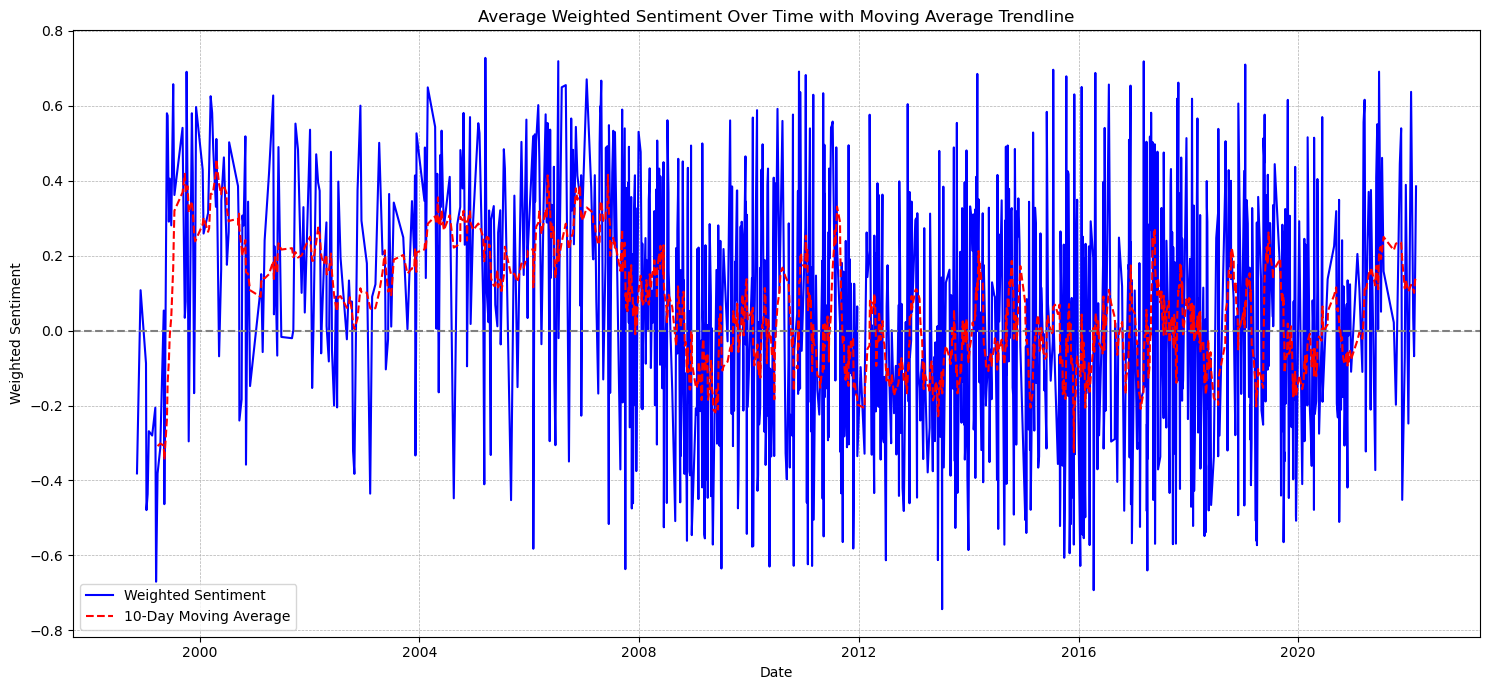

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming gen_data is your dataframe
# Convert the date column to datetime type for better plotting
gen_data['Date'] = pd.to_datetime(gen_data['Date'])

# Calculate the moving average. Adjust the window size as needed.
window_size = 10  # Adjust this as per your preference
gen_data['moving_avg'] = gen_data['weighted_prob'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(15,7))
plt.plot(gen_data['Date'], gen_data['weighted_prob'], label='Weighted Sentiment', color='blue')
plt.plot(gen_data['Date'], gen_data['moving_avg'], "r--", label=f'{window_size}-Day Moving Average')
plt.axhline(y=0, color='grey', linestyle='--')  # A line at y=0 for reference

plt.title('Average Weighted Sentiment Over Time with Moving Average Trendline')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Bring other time series variables

In [38]:
import yfinance as yf
import pandas as pd

# Define the path to your data file
data_path = "src/Data/stoxx.txt"

# Read the data file into a DataFrame
vstoxx_df = pd.read_csv(data_path, delimiter=";", parse_dates=["Date"], dayfirst=True)

# Change the date format to DD-MM-YYYY
vstoxx_df["Date_merge"] = vstoxx_df["Date"].dt.strftime("%d-%m-%Y")

# generate day of the week column
vstoxx_df['day_of_week'] = pd.to_datetime(vstoxx_df['Date']).dt.day_name()

# generate month column
vstoxx_df['month'] = pd.to_datetime(vstoxx_df['Date']).dt.month_name()

# calculate the daily change in the index
vstoxx_df['delta_daily'] = vstoxx_df['Indexvalue'].diff()
#vstoxx_df['delta_3d'] = vstoxx_df['Indexvalue'].diff(3)
#vstoxx_df['delta_5d'] = vstoxx_df['Indexvalue'].diff(5)
#vstoxx_df['delta_30d'] = vstoxx_df['Indexvalue'].diff(30)
#vstoxx_df['3d_pp_change'] = vstoxx_df['Indexvalue'].pct_change(3)
vstoxx_df['shifted_1_day'] = vstoxx_df['Indexvalue'].shift(-2)
vstoxx_df['delta_shifted'] = vstoxx_df['Indexvalue'] - vstoxx_df['shifted_1_day']
vstoxx_df['delta_shifted_2'] = vstoxx_df['delta_shifted'].shift(1)
# Display the DataFrame
vstoxx_df


,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,shifted_1_day,delta_shifted,delta_shifted_2
0,1999-01-04,V2TX,18.2033,04-01-1999,Monday,January,NaN,25.1670,-6.9637,NaN
1,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,32.5205,-2.8293,-6.9637
2,1999-01-06,V2TX,25.1670,06-01-1999,Wednesday,January,-4.5242,33.2296,-8.0626,-2.8293
3,1999-01-07,V2TX,32.5205,07-01-1999,Thursday,January,7.3535,36.8411,-4.3206,-8.0626
4,1999-01-08,V2TX,33.2296,08-01-1999,Friday,January,0.7091,37.5664,-4.3368,-4.3206
...,...,...,...,...,...,...,...,...,...,...
6268,2023-08-15,V2TX,18.8579,15-08-2023,Tuesday,August,0.8050,20.3539,-1.4960,-0.4981
6269,2023-08-16,V2TX,18.5510,16-08-2023,Wednesday,August,-0.3069,20.2456,-1.6946,-1.4960
6270,2023-08-17,V2TX,20.3539,17-08-2023,Thursday,August,1.8029,19.8367,0.5172,-1.6946
6271,2023-08-18,V2TX,20.2456,18-08-2023,Friday,August,-0.1083,NaN,NaN,0.5172


# Bond price data

In [39]:
bond_data = pd.read_csv("src/Data/10_year_maturity.csv")
# change variable names to Date and 10_y_bond_yield
bond_data.columns = ['Date', 'Date_2', '10_y_bond_yield']
# drop the second date column
bond_data = bond_data.drop(columns=['Date_2'])
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
bond_data

,Date,10_y_bond_yield
0,2004-09-06,4.209220
1,2004-09-07,4.209626
2,2004-09-08,4.228419
3,2004-09-09,4.161872
4,2004-09-10,4.120981
...,...,...
4867,2023-09-15,2.734948
4868,2023-09-18,2.788173
4869,2023-09-19,2.807675
4870,2023-09-20,2.765770


In [40]:
# import the yield curve data
yield_curve = pd.read_csv("src/Data/euro_yield_curve.csv")

# Select only 'date' and 's1' columns
yield_curve = yield_curve[['date', 's1']]

# Rename the 's1' column to 's1_yield'
yield_curve.rename(columns={'s1': 's1_yield'}, inplace=True)
yield_curve.rename(columns={'date': 'Date'}, inplace=True)


yield_curve 

,Date,s1_yield
0,2004-09-06,3.298175
1,2004-09-07,3.338711
2,2004-09-08,3.375993
3,2004-09-09,3.284360
4,2004-09-10,3.208441
...,...,...
4843,2023-08-14,2.370727
4844,2023-08-15,2.448853
4845,2023-08-16,2.428063
4846,2023-08-17,2.466451


In [41]:
ref_rate = pd.read_csv("src/Data/main_ref_rate.csv")
# keep only date, s3, s8 and s10
ref_rate = ref_rate[['date', 's3', 's8', 's10']]
# input the last value to the NaNs
ref_rate['s3'] = ref_rate['s3'].fillna(method='ffill')
# remove the NaNs
ref_rate = ref_rate.dropna()
# transform 1998-12-31 24:00:00 to 1999-01-01 00:00:00 format in date column
ref_rate['Date'] = ref_rate['date'].str.replace(' 24:00:00', ' 00:00:00')
# convert date to datetime format

ref_rate['Date'] = pd.to_datetime(ref_rate['Date'])
ref_rate.drop(columns=['date'], inplace=True)
ref_rate


,s3,s8,s10,Date
3,-1.25,0.75,-1.25,1999-01-03
4,-1.25,0.75,-1.25,1999-01-04
5,-1.25,0.75,-1.25,1999-01-05
6,-1.25,0.75,-1.25,1999-01-06
7,-1.25,0.75,-1.25,1999-01-07
...,...,...,...,...
9005,0.25,0.25,0.25,2023-08-27
9006,0.25,0.25,0.25,2023-08-28
9007,0.25,0.25,0.25,2023-08-29
9008,0.25,0.25,0.25,2023-08-30


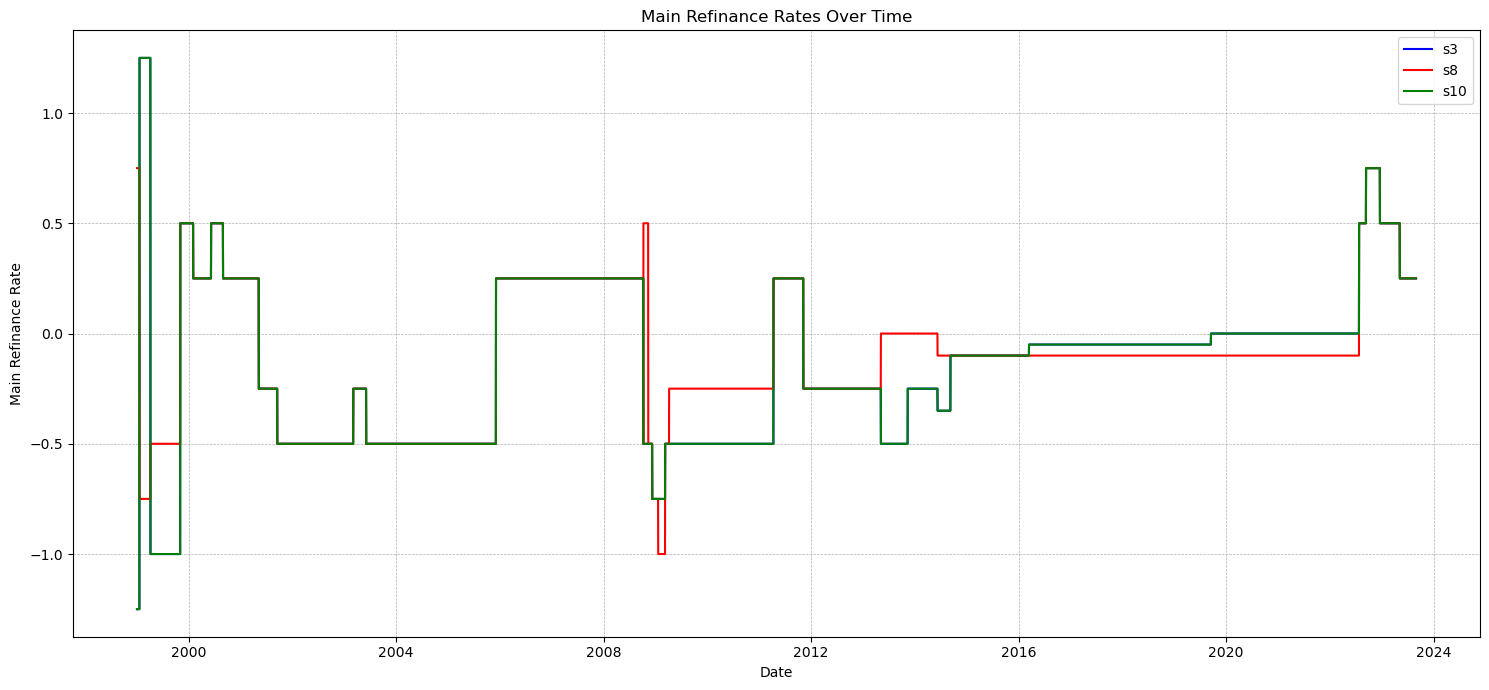

In [42]:
# plot s3, s8 and s10 rates over time
plt.figure(figsize=(15,7))
plt.plot(ref_rate['Date'], ref_rate['s3'], label='s3', color='blue')
plt.plot(ref_rate['Date'], ref_rate['s8'], label='s8', color='red')
plt.plot(ref_rate['Date'], ref_rate['s10'], label='s10', color='green')
plt.title('Main Refinance Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Main Refinance Rate')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Labor and unemployment data

In [43]:
# import and transform the data for labor productivity
labor = pd.read_csv("src/Data/Labor_productivity.csv")

# import and transform the data for unemployment
unemployment = pd.read_csv("src/Data/Unemployment.csv")

In [44]:
unemployment

,date,conf,status1,s1
0,2000-01-30 24:00:00,NaN,Normal value,9.44
1,2000-02-28 24:00:00,NaN,Normal value,9.35
2,2000-03-30 24:00:00,NaN,Normal value,9.26
3,2000-04-29 24:00:00,NaN,Normal value,9.18
4,2000-05-30 24:00:00,NaN,Normal value,9.12
...,...,...,...,...
277,2023-02-27 24:00:00,NaN,Normal value,6.59
278,2023-03-30 24:00:00,NaN,Normal value,6.52
279,2023-04-29 24:00:00,NaN,Normal value,6.45
280,2023-05-30 24:00:00,NaN,Normal value,6.40


In [45]:
# Adjust the time and increment the date
def adjust_time(date_string):
    if '24:00:00' in date_string:
        date_string = date_string.replace('24:00:00', '00:00:00')
        date_object = pd.to_datetime(date_string) + pd.Timedelta(days=1)
        return date_object.date()
    else:
        return pd.to_datetime(date_string).date()

labor['Date'] = labor['date'].apply(adjust_time)
unemployment['Date'] = unemployment['date'].apply(adjust_time)

In [46]:
import pandas as pd

# Sample data loading (you might have your own way of reading these dataframes)
# labor = pd.read_csv("path_to_labor.csv")
# unemployment = pd.read_csv("path_to_unemployment.csv")

# Merge the dataframes using an outer join
labor_unemployment = pd.merge(labor[['Date', 's1']], 
                              unemployment[['date', 's1']], 
                              left_on='Date', 
                              right_on='date', 
                              how='outer', 
                              suffixes=('_labor', '_unemployment'))

# Drop redundant date column
labor_unemployment.drop(columns=['Date'], inplace=True)

# Rename columns for clarity
labor_unemployment.rename(columns={
    'date': 'Date',
    's1_labor': 'labor_prod_s1', 
    's1_unemployment': 'unemployment_s1'
}, inplace=True)

# Handle missing values by forward filling
labor_unemployment['labor_prod_s1'] = labor_unemployment['labor_prod_s1'].fillna(method='ffill')
labor_unemployment['unemployment_s1'] = labor_unemployment['unemployment_s1'].fillna(method='ffill')

# Display the merged dataframe
labor_unemployment

,labor_prod_s1,Date,unemployment_s1
0,0.22,NaN,NaN
1,0.38,NaN,NaN
2,1.01,NaN,NaN
3,2.01,NaN,NaN
4,1.96,NaN,NaN
...,...,...,...
375,-0.77,2023-02-27 24:00:00,6.59
376,-0.77,2023-03-30 24:00:00,6.52
377,-0.77,2023-04-29 24:00:00,6.45
378,-0.77,2023-05-30 24:00:00,6.40


# Dax data

In [47]:
dax_selected = pd.read_csv("src/Data/^GDAXI.csv")

# keep only date, close and volume
dax_selected = dax_selected[['Date', 'Close', 'Volume']]
dax_selected.rename(columns={'Close': 'Close_dax', 'Volume':'Volume_dax'}, inplace=True)
dax_selected

,Date,Close_dax,Volume_dax
0,2000-01-03,6750.759766,43072500.0
1,2000-01-04,6586.950195,46678400.0
2,2000-01-05,6502.069824,52682800.0
3,2000-01-06,6474.919922,41180600.0
4,2000-01-07,6780.959961,56058900.0
...,...,...,...
6064,2023-09-18,15727.120117,58899600.0
6065,2023-09-19,15664.480469,53581800.0
6066,2023-09-20,15781.589844,54733100.0
6067,2023-09-21,15571.860352,65995100.0


In [48]:
# import volatility data
volatility = pd.read_csv("src/Data/^EVZ volatility.csv")
# keep only date and close
volatility = volatility[['Date', 'Close']]
# rename close to close_volatility
volatility.rename(columns={'Close': 'Close_volatility'}, inplace=True)
volatility

,Date,Close_volatility
0,2008-09-25,14.420000
1,2008-09-26,14.990000
2,2008-09-29,15.320000
3,2008-09-30,18.719999
4,2008-10-01,17.280001
...,...,...
3769,2023-09-18,6.750000
3770,2023-09-19,6.920000
3771,2023-09-20,6.800000
3772,2023-09-21,7.250000


# Merge all of them into one


In [49]:
dfs = [gen_data, vstoxx_df, bond_data, yield_curve, ref_rate, labor_unemployment, dax_selected, volatility]
# Ensure 'Date' columns of all dataframes are corrected and of type datetime64[ns]
for df in dfs:
    # Convert 'Date' column to string for string operations
    df['Date'] = df['Date'].astype(str)
    
    # Replace '24:00:00' with '00:00:00' and add a day
    mask = df['Date'].str.contains('24:00:00', na=False)
    df.loc[mask, 'Date'] = pd.to_datetime(df['Date'].str.replace('24:00:00', '00:00:00')) + pd.Timedelta(days=1)
    
    # Convert to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

# Initialize 'merged_df' with the first dataframe
merged_df = dfs[0].copy()

# Iteratively merge the other dataframes
for i, df in enumerate(dfs[1:], 2):  # Start enumeration at 2 for suffix purposes
    # Find overlapping columns (other than 'Date')
    overlapping_columns = df.columns[df.columns.isin(merged_df.columns) & (df.columns != 'Date')]
    
    # For overlapping columns in the next dataframe, add suffixes
    df = df.rename(columns={col: f"{col}_df{i}" for col in overlapping_columns})
    
    # Merge
    merged_df = merged_df.merge(df, on='Date', how='outer')

# Display the merged dataframe
merged_df
# print(merged_df.shape)


,Date,content,negative_counts,neutral_counts,positive_counts,positive_max,positive_min,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel,moving_avg,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,shifted_1_day,delta_shifted,delta_shifted_2,10_y_bond_yield,s1_yield,s3,s8,s10,labor_prod_s1,unemployment_s1,Close_dax,Volume_dax,Close_volatility
0,1998-11-09,Mr. Duisenberg’s opening statement at the pres...,6.0,13.0,2.0,0.899266,0.765561,0.832413,0.962060,0.523458,0.785708,0.948906,0.531514,0.870117,-0.381178,speech,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-12-03,Mr Duisenberg reports on the current position ...,2.0,14.0,3.0,0.808924,0.565346,0.677796,0.847879,0.645703,0.746791,0.952718,0.680924,0.828251,0.107961,speech,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-08,Mr Duisenberg’s opening statement at the press...,2.0,18.0,2.0,0.923603,0.554621,0.739112,0.947072,0.880715,0.913893,0.949159,0.535464,0.845749,-0.087391,speech,NaN,V2TX,33.2296,08-01-1999,Friday,January,0.7091,37.5664,-4.3368,-4.3206,NaN,NaN,-1.25,0.75,-1.25,NaN,NaN,NaN,NaN,NaN
3,1999-01-11,Mr Duisenberg’s opening statement at the press...,10.0,23.0,2.0,0.817296,0.668759,0.743027,0.954375,0.496729,0.723577,0.950720,0.375282,0.818889,-0.479143,speech,NaN,V2TX,36.8411,11-01-1999,Monday,January,3.6115,39.7373,-2.8962,-4.3368,NaN,NaN,-1.25,0.75,-1.25,NaN,NaN,NaN,NaN,NaN
4,1999-01-19,Mr Duisenberg’s opening statement at the Europ...,6.0,16.0,2.0,0.870406,0.866672,0.868539,0.968294,0.739333,0.871450,0.946656,0.559591,0.827322,-0.436452,speech,NaN,V2TX,38.7869,19-01-1999,Tuesday,January,0.2430,36.9171,1.8698,2.9904,NaN,NaN,-1.25,0.75,-1.25,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.52,NaN,NaN,NaN,NaN
9119,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,NaN,NaN,NaN,NaN
9120,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.47,NaN,NaN,NaN,NaN
9121,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.77,NaN,NaN,NaN,NaN


In [50]:
merged_df.columns.tolist()


['Date',
 'content',
 'negative_counts',
 'neutral_counts',
 'positive_counts',
 'positive_max',
 'positive_min',
 'positive_mean',
 'negative_max',
 'negative_min',
 'negative_mean',
 'neutral_max',
 'neutral_min',
 'neutral_mean',
 'weighted_prob',
 'info_channel',
 'moving_avg',
 'Symbol',
 'Indexvalue',
 'Date_merge',
 'day_of_week',
 'month',
 'delta_daily',
 'shifted_1_day',
 'delta_shifted',
 'delta_shifted_2',
 '10_y_bond_yield',
 's1_yield',
 's3',
 's8',
 's10',
 'labor_prod_s1',
 'unemployment_s1',
 'Close_dax',
 'Volume_dax',
 'Close_volatility']

In [51]:
# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

print(nan_table)


                  NaN/Null Count
Date                          98
content                     7871
negative_counts             7871
neutral_counts              7871
positive_counts             7871
positive_max                7871
positive_min                7871
positive_mean               7871
negative_max                7871
negative_min                7871
negative_mean               7871
neutral_max                 7871
neutral_min                 7871
neutral_mean                7871
weighted_prob               7871
info_channel                7871
moving_avg                  7880
Symbol                      2850
Indexvalue                  2850
Date_merge                  2850
day_of_week                 2850
month                       2850
delta_daily                 2851
shifted_1_day               2852
delta_shifted               2852
delta_shifted_2             2852
10_y_bond_yield             4251
s1_yield                    4275
s3                           116
s8        

In [52]:
"""
columns_to_fill = [
    'Close_dax',
    'Volume_dax',
    'Close_vdax',
    'Volume_vdax',
    'labor_prod_s1',
    'unemployment_s1',
    's1_yield',
    'bond_price',
    'b_delta_daily',
    'Indexvalue'
]

for column in columns_to_fill:
    merged_df[column] = merged_df[column].fillna(method='ffill')

merged_df
"""

"\ncolumns_to_fill = [\n    'Close_dax',\n    'Volume_dax',\n    'Close_vdax',\n    'Volume_vdax',\n    'labor_prod_s1',\n    'unemployment_s1',\n    's1_yield',\n    'bond_price',\n    'b_delta_daily',\n    'Indexvalue'\n]\n\nfor column in columns_to_fill:\n    merged_df[column] = merged_df[column].fillna(method='ffill')\n\nmerged_df\n"

In [56]:
# Filter the rows based on the 'Date' column
merged_df = merged_df[merged_df['Date'] > '2005-01-01']

# filter and keep only where weighted_prob	exists
merged_df = merged_df[merged_df['weighted_prob'].notna()]

# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

nan_table


,NaN/Null Count
Date,0
content,0
negative_counts,0
neutral_counts,0
positive_counts,0
positive_max,0
positive_min,0
positive_mean,0
negative_max,0
negative_min,0


In [71]:
# display dataframe with all the columns 
pd.set_option('display.max_columns', None)
merged_df['labor_prod_s1'] = merged_df['labor_prod_s1'].fillna(method='ffill')
merged_df['unemployment_s1'] = merged_df['unemployment_s1'].fillna(method='ffill')

# for all previous rows of labor and unemployment, fill NaNs with 0
merged_df['labor_prod_s1'] = merged_df['labor_prod_s1'].fillna(0)
merged_df['unemployment_s1'] = merged_df['unemployment_s1'].fillna(0)

# fill NaNs with its previous value in Close_volatility column
merged_df['Close_volatility'] = merged_df['Close_volatility'].fillna(method='ffill')
# fill initial NaNs with 0
merged_df['Close_volatility'] = merged_df['Close_volatility'].fillna(0)

merged_df

,Date,content,negative_counts,neutral_counts,positive_counts,positive_max,positive_min,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel,moving_avg,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,shifted_1_day,delta_shifted,delta_shifted_2,10_y_bond_yield,s1_yield,s3,s8,s10,labor_prod_s1,unemployment_s1,Close_dax,Volume_dax,Close_volatility
159,2005-01-26,Jean-Claude Trichet: The euro - successes and ...,1.0,10.0,8.0,0.882642,0.466327,0.687462,0.515659,0.515659,0.515659,0.927084,0.479027,0.698223,0.553782,speech,0.285913,V2TX,13.3240,26-01-2005,Wednesday,January,-0.3040,12.8050,0.5190,1.1660,3.573076,2.802277,-0.5,-0.5,-0.5,0.00,0.00,4214.120117,141212200.0,0.00
160,2005-02-03,Jean-Claude Trichet: Interview with Les Echos ...,1.0,39.0,9.0,0.807713,0.362695,0.646132,0.540062,0.540062,0.540062,0.944788,0.507110,0.804610,0.527512,speech,0.280547,V2TX,12.3844,03-02-2005,Thursday,February,0.1339,11.9934,0.3910,0.6539,3.554661,2.841413,-0.5,-0.5,-0.5,0.00,0.00,4281.640137,96153600.0,0.00
161,2005-02-28,Jean-Claude Trichet: Monetary policy and priva...,4.0,33.0,5.0,0.794457,0.461968,0.668889,0.808487,0.560649,0.681837,0.940553,0.521477,0.827575,0.068567,speech,0.249022,V2TX,12.8907,28-02-2005,Monday,February,0.6800,12.8591,0.0316,-0.1395,3.710944,2.970440,-0.5,-0.5,-0.5,-0.77,9.29,4350.490234,110897300.0,0.00
162,2005-03-07,European Central Bank: Press conference - intr...,5.0,4.0,2.0,0.740040,0.507554,0.623797,0.973803,0.643690,0.823827,0.768903,0.595795,0.651477,-0.410220,speech,0.185070,V2TX,11.7178,07-03-2005,Monday,March,-0.2132,12.5319,-0.8141,-0.0710,3.681450,2.862540,-0.5,-0.5,-0.5,-0.77,9.29,4428.089844,81185200.0,0.00
163,2005-03-14,Jean-Claude Trichet: Economic and financial in...,1.0,22.0,14.0,0.952844,0.511849,0.819305,0.547662,0.547662,0.547662,0.926835,0.487195,0.756132,0.728174,speech,0.230004,V2TX,13.3498,14-03-2005,Monday,March,0.3932,14.5708,-1.2210,0.4620,3.794177,2.946157,-0.5,-0.5,-0.5,-0.77,9.29,4367.299805,69258200.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2022-01-21,Christine Lagarde: Introductory statement at t...,1.0,7.0,10.0,0.953582,0.613189,0.747925,0.466378,0.466378,0.466378,0.839482,0.542453,0.744504,0.637534,speech,0.122252,V2TX,24.2217,21-01-2022,Friday,January,3.8184,31.4530,-7.2313,-12.2778,-0.079525,-0.500242,0.0,-0.1,0.0,-0.77,8.56,15603.879883,105899500.0,5.92
1248,2022-02-04,Christine Lagarde: Introductory statement at E...,4.0,1.0,4.0,0.954398,0.446699,0.824757,0.943139,0.491753,0.756767,0.539072,0.539072,0.539072,0.033995,speech,0.109810,V2TX,26.3008,04-02-2022,Friday,February,1.9721,23.1564,3.1444,0.0854,0.195480,0.044753,0.0,-0.1,0.0,-0.77,8.56,15099.559570,93799100.0,6.81
1249,2022-02-10,Christine Lagarde: Hearing of the Committee on...,4.0,5.0,3.0,0.953364,0.543439,0.779126,0.943748,0.461614,0.703850,0.872223,0.506347,0.692795,-0.068289,speech,0.100805,V2TX,21.8414,10-02-2022,Thursday,February,0.4297,30.0547,-8.2133,-3.2520,0.281690,0.023036,0.0,-0.1,0.0,-0.77,8.56,15490.440430,94694700.0,7.15
1250,2022-02-17,Christine Lagarde: Introductory statement - Eu...,3.0,8.0,5.0,0.946285,0.534803,0.763456,0.928384,0.727196,0.845817,0.895302,0.626179,0.816141,0.159978,speech,0.136591,V2TX,28.7931,17-02-2022,Thursday,February,2.1793,36.2245,-7.4314,-4.6531,0.279858,-0.089317,0.0,-0.1,0.0,-0.77,8.56,15267.629883,78678300.0,7.57


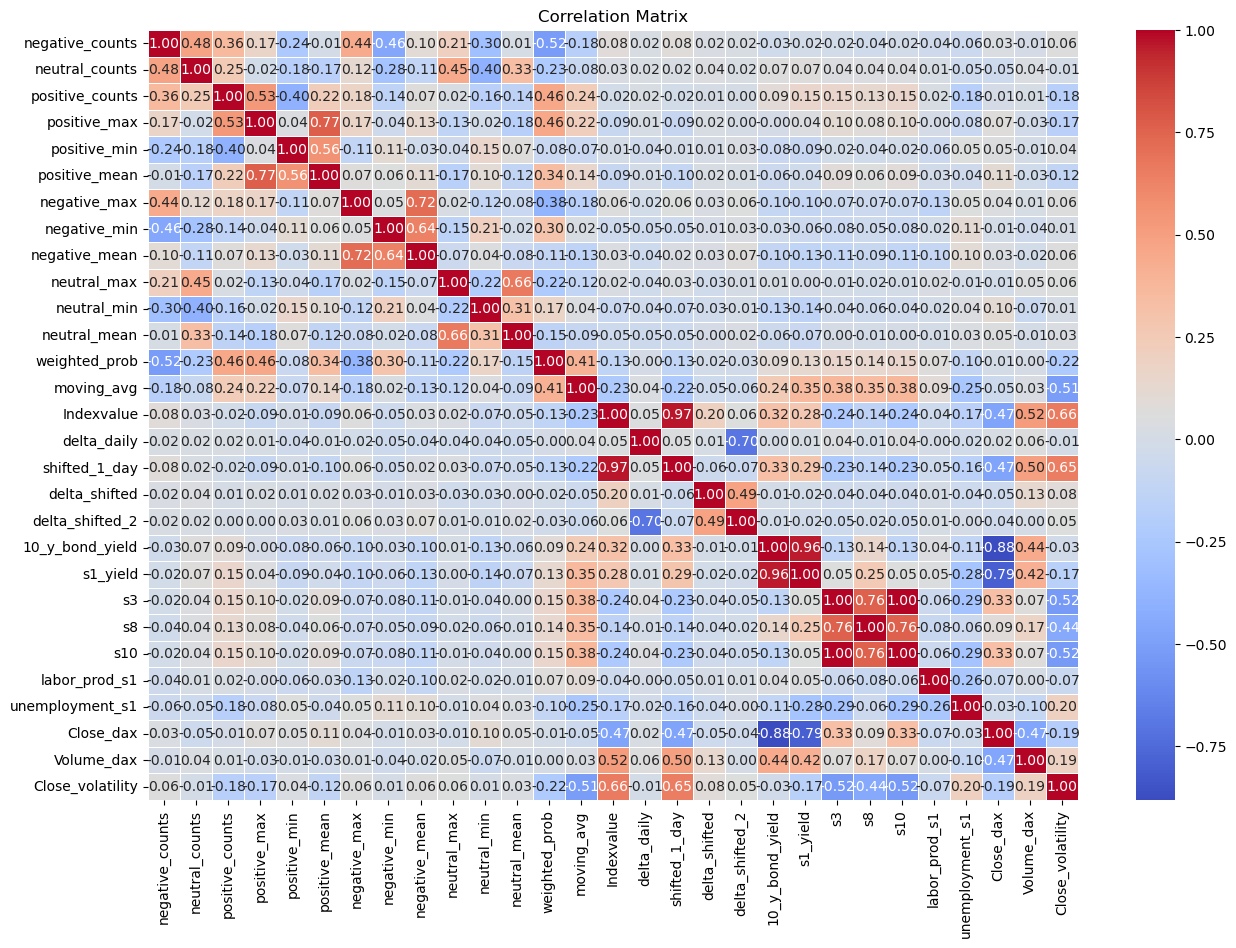

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [121]:
# Compute correlations of each column against 'weighted_prob'
correlations = {}
for col in merged_df.columns:
    if merged_df[col].dtype in ['float64', 'int64'] and col != 'weighted_prob':
        correlations[col] = merged_df[col].corr(merged_df['weighted_prob'])

# Convert dictionary to a DataFrame for better visualization and sorting
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'Correlation_with_weighted_prob'])

# Sort by the absolute value of correlation to get a ranking
correlation_df['Abs_Correlation'] = correlation_df['Correlation_with_weighted_prob'].abs()
correlation_df = correlation_df.sort_values(by='Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

# Display the ranked correlations
print(correlation_df)


            Variable  Correlation_with_weighted_prob
0    negative_counts                       -0.518381
2    positive_counts                        0.462270
3       positive_max                        0.461506
12        moving_avg                        0.409274
6       negative_max                       -0.380445
5      positive_mean                        0.344238
7       negative_min                        0.297973
1     neutral_counts                       -0.226888
9        neutral_max                       -0.224788
27  Close_volatility                       -0.223324
10       neutral_min                        0.167157
22               s10                        0.149518
20                s3                        0.149518
11      neutral_mean                       -0.145156
21                s8                        0.135220
19          s1_yield                        0.130959
13        Indexvalue                       -0.129328
15     shifted_1_day                       -0.

# LSTM model with proper data preprocessing

In [204]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract data
features = merged_df[['Date','Indexvalue','10_y_bond_yield', 'weighted_prob', 'shifted_1_day', 'day_of_week', 's10',
                       'moving_avg','labor_prod_s1', 'unemployment_s1','Close_dax',  'Volume_dax']]#, 'Close_volatility']]

features = features[features['day_of_week'].notna()]

features['Close_dax'] = features['Close_dax'].fillna(method='ffill')
features['Volume_dax'] = features['Volume_dax'].fillna(method='ffill')

# count nans
features.isnull().sum()
# reset index
features = features.reset_index(drop=True)



In [205]:
# store the dates for later visualization 
dates_series = features['Date']


,Date,Indexvalue,10_y_bond_yield,weighted_prob,shifted_1_day,day_of_week,s10,moving_avg,labor_prod_s1,unemployment_s1,Close_dax,Volume_dax
0,2005-01-26,13.3240,3.573076,0.553782,12.8050,Wednesday,-0.5,0.285913,0.00,0.00,4214.120117,141212200.0
1,2005-02-03,12.3844,3.554661,0.527512,11.9934,Thursday,-0.5,0.280547,0.00,0.00,4281.640137,96153600.0
2,2005-02-28,12.8907,3.710944,0.068567,12.8591,Monday,-0.5,0.249022,-0.77,9.29,4350.490234,110897300.0
3,2005-03-07,11.7178,3.681450,-0.410220,12.5319,Monday,-0.5,0.185070,-0.77,9.29,4428.089844,81185200.0
4,2005-03-14,13.3498,3.794177,0.728174,14.5708,Monday,-0.5,0.230004,-0.77,9.29,4367.299805,69258200.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2022-01-21,24.2217,-0.079525,0.637534,31.4530,Friday,0.0,0.122252,-0.77,8.56,15603.879883,105899500.0
1087,2022-02-04,26.3008,0.195480,0.033995,23.1564,Friday,0.0,0.109810,-0.77,8.56,15099.559570,93799100.0
1088,2022-02-10,21.8414,0.281690,-0.068289,30.0547,Thursday,0.0,0.100805,-0.77,8.56,15490.440430,94694700.0
1089,2022-02-17,28.7931,0.279858,0.159978,36.2245,Thursday,0.0,0.136591,-0.77,8.56,15267.629883,78678300.0


In [206]:
features['Close_dax'] = features['Close_dax'].fillna(method='ffill')
features['Volume_dax'] = features['Volume_dax'].fillna(method='ffill')

# count nans
features.isnull().sum()

Date               0
Indexvalue         0
10_y_bond_yield    0
weighted_prob      0
shifted_1_day      0
day_of_week        0
s10                0
moving_avg         0
labor_prod_s1      0
unemployment_s1    0
Close_dax          0
Volume_dax         0
dtype: int64

In [220]:
# Lagging features by one day (for everything except 'Date' and 'Indexvalue')
for column in features.columns:
    if column not in ['Date', 'Indexvalue']:
        features[column] = features[column].shift(1)

# Drop the NaN row resulting from the shift
features = features.dropna()

# Resetting index
features = features.reset_index(drop=True)

In [221]:
features

,Date,Indexvalue,10_y_bond_yield,weighted_prob,shifted_1_day,s10,moving_avg,labor_prod_s1,unemployment_s1,Close_dax,Volume_dax,Monday,Thursday,Tuesday,Wednesday
0,2005-02-03,12.3844,3.573076,0.553782,12.8050,-0.5,0.285913,0.00,0.00,4214.120117,141212200.0,False,False,False,True
1,2005-02-28,12.8907,3.554661,0.527512,11.9934,-0.5,0.280547,0.00,0.00,4281.640137,96153600.0,False,True,False,False
2,2005-03-07,11.7178,3.710944,0.068567,12.8591,-0.5,0.249022,-0.77,9.29,4350.490234,110897300.0,True,False,False,False
3,2005-03-14,13.3498,3.681450,-0.410220,12.5319,-0.5,0.185070,-0.77,9.29,4428.089844,81185200.0,True,False,False,False
4,2005-03-23,13.4667,3.794177,0.728174,14.5708,-0.5,0.230004,-0.77,9.29,4367.299805,69258200.0,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,2022-01-21,24.2217,-0.123137,-0.248018,17.7553,0.0,0.104626,-0.77,8.56,16020.730469,56865800.0,True,False,False,False
1086,2022-02-04,26.3008,-0.079525,0.637534,31.4530,0.0,0.122252,-0.77,8.56,15603.879883,105899500.0,False,False,False,False
1087,2022-02-10,21.8414,0.195480,0.033995,23.1564,0.0,0.109810,-0.77,8.56,15099.559570,93799100.0,False,False,False,False
1088,2022-02-17,28.7931,0.281690,-0.068289,30.0547,0.0,0.100805,-0.77,8.56,15490.440430,94694700.0,False,True,False,False


In [222]:
# 1. Handle the 'day_of_week' feature if it exists in your DataFrame
if 'day_of_week' in features.columns:
    dummies = pd.get_dummies(features['day_of_week'], drop_first=True)  # drop_first avoids multicollinearity
    features = features.drop('day_of_week', axis=1)
    features = pd.concat([features, dummies], axis=1)


In [223]:
# 2. Scale the data but exclude the 'Date' column

features_without_date = features.drop(columns=['Date'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_without_date = scaler.fit_transform(features_without_date)


In [224]:

# Convert the scaled data back to a DataFrame and re-add the 'Date' column
scaled_df = pd.DataFrame(scaled_data_without_date, columns=features_without_date.columns)
scaled_df['Date'] = dates_series.reset_index(drop=True)

# If you want to use scaled_df for LSTM sequences, remove the 'Date' column again
scaled_data = scaled_df.drop(columns=['Date']).values

sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y.append(scaled_data[i, 0])  # Target column

# Adjust the reshaping step to consider all features dynamically
num_features = scaled_data.shape[1] - 1  # Subtracting 1 for the target column

X, y = np.array(X), np.array(y)

X = np.reshape(X, (-1, sequence_length, num_features))

In [225]:
X.shape, y.shape

((1060, 30, 13), (1060,))

In [226]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

import numpy as np
import tensorflow as tf
import random
import os
# 1. Set Python's random seed
random.seed(42)

# 2. Set Numpy's random seed
np.random.seed(42)

# 3. Set TensorFlow's random seed
tf.random.set_seed(42)

# If you're using a GPU, set deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Assuming 'features' and 'targets' are already created and split as X and y, respectively.

# Split data (80% train, 20% test)
train_size = int(0.7 * len(dates_series))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dates_train = dates_series[:train_size].reset_index(drop=True)
dates_test = dates_series[train_size:].reset_index(drop=True)

# save the dates
dates_train = dates_series[:train_size]
dates_test = dates_series[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features))) # Use num_features instead of 4
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and store its history
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Access training and validation loss (can be plotted or analyzed further)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Evaluate model
predicted_bond_price = model.predict(X_test)

# Assuming the original number of features (excluding 'Date') is 10
# num_original_features = 13
num_original_features = features.shape[1] - 1 
# Create a dummy array with the same number of rows as `predicted_bond_price`
# and the same number of columns as the original data
temp_array = np.zeros((predicted_bond_price.shape[0], num_original_features))

# Fill the first column with `predicted_bond_price` values
temp_array[:, 0] = predicted_bond_price.ravel()

# Now inverse transform this array
inverse_transformed = scaler.inverse_transform(temp_array)

# Extract the bond_price predictions from the first column
final_predicted_bond_price = inverse_transformed[:, 0]


Epoch 1/50
12/12 [==============================] - 4s 78ms/step - loss: 0.0284 - val_loss: 0.0144
Epoch 2/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 3/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 4/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0087 - val_loss: 0.0119
Epoch 5/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0067 - val_loss: 0.0113
Epoch 6/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0061 - val_loss: 0.0111
Epoch 7/50
12/12 [==============================] - 0s 27ms/step - loss: 0.0061 - val_loss: 0.0095
Epoch 8/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0062 - val_loss: 0.0128
Epoch 9/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0055 - val_loss: 0.0118
Epoch 10/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0046 - val_loss: 0.0113
Epoch 11/

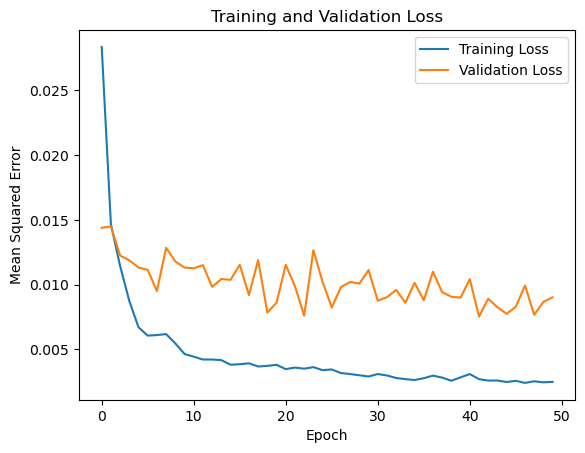

In [227]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [228]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {test_mse}")


Mean Squared Error on test set: 0.00901742372661829


In [229]:
# Calculate RMSE from the given MSE
rmse_standardized = np.sqrt(test_mse)

# Create a dummy array with this RMSE value in the first column and zeros elsewhere
rmse_array_standardized = np.zeros((1, num_original_features))
rmse_array_standardized[0, 0] = rmse_standardized

# Now inverse transform this array
rmse_real_value_array = scaler.inverse_transform(rmse_array_standardized)

# Extract the RMSE in real value terms
rmse_real_value = rmse_real_value_array[0, 0]
rmse_real_value


17.306861609519434

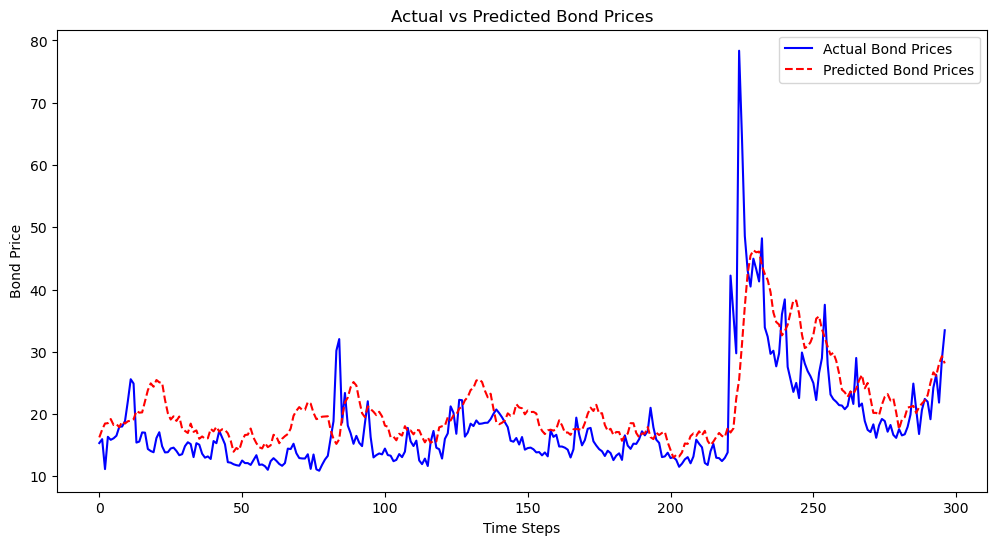

In [230]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Preparing the data for inverse transformation
# ----------------------------------------------

# Convert y_test to a 2D array for compatibility with the transformation process
y_test_2d = y_test.reshape(-1, 1)

# Number of original features minus 'Date'
num_original_features = features.shape[1] - 1

# Create a placeholder array with adjusted size
placeholder_array = np.zeros((y_test_2d.shape[0], num_original_features))

# Assign the bond prices from y_test to the first column of this placeholder array.
placeholder_array[:, 0] = y_test_2d.ravel()

# Step 2: Performing the inverse transformation
# ----------------------------------------------
actual_prices = scaler.inverse_transform(placeholder_array)[:, 0]

# Step 3: Plotting the actual vs predicted bond prices
# ----------------------------------------------------

predicted_prices = final_predicted_bond_price

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Bond Prices", color='blue')
plt.plot(predicted_prices, label="Predicted Bond Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Bond Prices")
plt.xlabel("Time Steps")
plt.ylabel("Bond Price")
plt.show()


In [231]:
mse = history.history['val_loss'][-1]  # Taking the last value from the validation loss
standard_error = np.sqrt(mse)
confidence_margin = 1.96 * standard_error

# Convert y_train to a 2D array for compatibility
y_train_2d = y_train.reshape(-1, 1)

# Create a placeholder array for y_train with adjusted size
placeholder_array_train = np.zeros((y_train_2d.shape[0], num_original_features))

# Assign the bond prices from y_train to the first column of this placeholder array
placeholder_array_train[:, 0] = y_train_2d.ravel()

# Perform the inverse transformation
actual_train_prices = scaler.inverse_transform(placeholder_array_train)[:, 0]

predicted_train_bond_price = model.predict(X_train)

# Create a dummy array for inverse transformation
temp_array_train = np.zeros((predicted_train_bond_price.shape[0], num_original_features))

# Fill the first column with `predicted_train_bond_price` values
temp_array_train[:, 0] = predicted_train_bond_price.ravel()

# Now inverse transform this array
inverse_transformed_train = scaler.inverse_transform(temp_array_train)

# Extract the bond_price predictions for the training set
final_predicted_train_bond_price = inverse_transformed_train[:, 0]


24/24 [==============================] - 0s 5ms/step


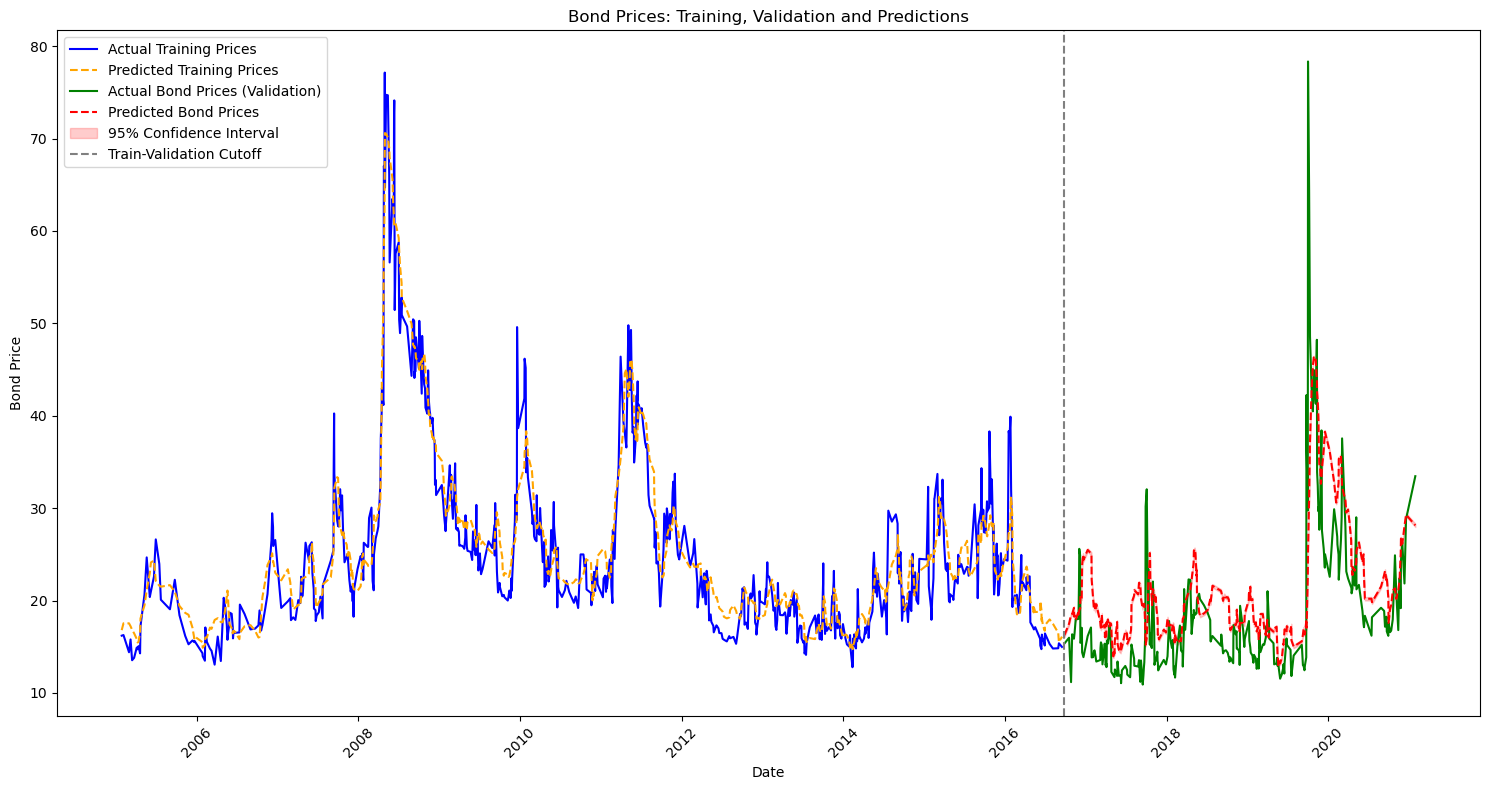

In [232]:

plt.figure(figsize=(15, 8))

# Plotting the training data with actual_train_prices
plt.plot(dates_series[:len(actual_train_prices)], actual_train_prices, label="Actual Training Prices", color='blue')

# Plotting the predicted bond prices for the training set
plt.plot(dates_series[:len(final_predicted_train_bond_price)], final_predicted_train_bond_price, label="Predicted Training Prices", color='orange', linestyle='dashed')

# Plotting the validation data (actual prices)
plt.plot(dates_series[len(actual_train_prices):len(actual_train_prices) + len(y_test)], actual_prices, label="Actual Bond Prices (Validation)", color='green')

# Plotting the predicted prices
plt.plot(dates_series[len(y_train):len(y_train) + len(y_test)], predicted_prices, label="Predicted Bond Prices", color='red', linestyle='dashed')

# Shading the 95% confidence interval
plt.fill_between(dates_series[len(y_train):len(y_train) + len(y_test)], 
                 (predicted_prices - confidence_margin), 
                 (predicted_prices + confidence_margin), 
                 color='red', 
                 alpha=0.2,
                 label='95% Confidence Interval')

# Highlighting the training-validation cutoff
plt.axvline(x=dates_series[len(y_train)], color='grey', linestyle='--', label="Train-Validation Cutoff")

plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.legend()
plt.title("Bond Prices: Training, Validation and Predictions")
plt.xlabel("Date")
plt.ylabel("Bond Price")
plt.tight_layout()
plt.show()


In [218]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



def build_model(lstm_units=50, optimizer=None, dropout_rate=0.0, sequence_length=None, num_features=None):
    model = Sequential()
    
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))
    
    # Use the optimizer passed in directly
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

def clone_optimizer(optimizer):
    config = optimizer.get_config()
    return type(optimizer)(**config)


In [219]:

# Define the hyperparameter grid
lstm_units_options = [30, 50, 70]
optimizers = [Adam(learning_rate=0.001), SGD(), RMSprop()]
dropout_rates = [0.1, 0.2, 0.3]

# Use grid search for hyperparameter tuning
best_val_loss = float('inf')
best_params = {}

for lstm_units in lstm_units_options:
    for optimizer in optimizers:
        for dropout_rate in dropout_rates:
            
            optimizer = clone_optimizer(optimizer)
            model = build_model(lstm_units=lstm_units, optimizer=optimizer, dropout_rate=dropout_rate, sequence_length=sequence_length, num_features=num_features)
            
            early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)
            
            history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr], verbose=0)
            
            # Get the best validation loss
            val_loss = min(history.history['val_loss'])
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'lstm_units': lstm_units,
                    'optimizer': optimizer,
                    'dropout_rate': dropout_rate
                }

print(f"Best validation loss: {best_val_loss}")
print("Best hyperparameters:", best_params)


Best validation loss: 0.00573966559022665
Best hyperparameters: {'lstm_units': 70, 'optimizer': <keras.src.optimizers.rmsprop.RMSprop object at 0x7efd77b05eb0>, 'dropout_rate': 0.1}


# Without average sentiments

In [234]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract data 
# taking out the 'weighted_prob' from the model
features_2 = merged_df[['Date','Indexvalue','10_y_bond_yield',  'shifted_1_day', 'day_of_week', 's10',
                       'moving_avg','labor_prod_s1', 'unemployment_s1','Close_dax',  'Volume_dax']]



features_2 = features_2[features_2['day_of_week'].notna()]

features_2['Close_dax'] = features_2['Close_dax'].fillna(method='ffill')
features_2['Volume_dax'] = features_2['Volume_dax'].fillna(method='ffill')

# count nans
features_2.isnull().sum()
# reset index
features_2 = features_2.reset_index(drop=True)

In [236]:
features_2

,Date,Indexvalue,10_y_bond_yield,shifted_1_day,day_of_week,s10,moving_avg,labor_prod_s1,unemployment_s1,Close_dax,Volume_dax
0,2005-01-26,13.3240,3.573076,12.8050,Wednesday,-0.5,0.285913,0.00,0.00,4214.120117,141212200.0
1,2005-02-03,12.3844,3.554661,11.9934,Thursday,-0.5,0.280547,0.00,0.00,4281.640137,96153600.0
2,2005-02-28,12.8907,3.710944,12.8591,Monday,-0.5,0.249022,-0.77,9.29,4350.490234,110897300.0
3,2005-03-07,11.7178,3.681450,12.5319,Monday,-0.5,0.185070,-0.77,9.29,4428.089844,81185200.0
4,2005-03-14,13.3498,3.794177,14.5708,Monday,-0.5,0.230004,-0.77,9.29,4367.299805,69258200.0
...,...,...,...,...,...,...,...,...,...,...,...
1086,2022-01-21,24.2217,-0.079525,31.4530,Friday,0.0,0.122252,-0.77,8.56,15603.879883,105899500.0
1087,2022-02-04,26.3008,0.195480,23.1564,Friday,0.0,0.109810,-0.77,8.56,15099.559570,93799100.0
1088,2022-02-10,21.8414,0.281690,30.0547,Thursday,0.0,0.100805,-0.77,8.56,15490.440430,94694700.0
1089,2022-02-17,28.7931,0.279858,36.2245,Thursday,0.0,0.136591,-0.77,8.56,15267.629883,78678300.0


In [238]:
# store the dates for later visualization 
dates_series = features['Date']

# make sure there are no nan values
features_2.isnull().sum()


Date               0
Indexvalue         0
10_y_bond_yield    0
shifted_1_day      0
day_of_week        0
s10                0
moving_avg         0
labor_prod_s1      0
unemployment_s1    0
Close_dax          0
Volume_dax         0
dtype: int64

In [241]:
# Lagging features by one day (for everything except 'Date' and 'Indexvalue')
for column in features_2.columns:
    if column not in ['Date', 'Indexvalue']:
        features_2[column] = features_2[column].shift(1)

# Drop the NaN row resulting from the shift
features_2 = features_2.dropna()

# Resetting index
features_2 = features_2.reset_index(drop=True)

In [243]:
# 1. Handle the 'day_of_week' feature if it exists in your DataFrame
if 'day_of_week' in features_2.columns:
    dummies = pd.get_dummies(features_2['day_of_week'], drop_first=True)  # drop_first avoids multicollinearity
    features_2 = features_2.drop('day_of_week', axis=1)
    features_2 = pd.concat([features_2, dummies], axis=1)


In [244]:
# 2. Scale the data but exclude the 'Date' column

features_without_date_2 = features_2.drop(columns=['Date'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_without_date_2 = scaler.fit_transform(features_without_date_2)

In [245]:
# Convert the scaled data back to a DataFrame and re-add the 'Date' column
scaled2_df = pd.DataFrame(scaled_data_without_date_2, columns=features_without_date_2.columns)
scaled2_df['Date'] = dates_series.reset_index(drop=True)

# If you want to use scaled_df for LSTM sequences, remove the 'Date' column again
scaled_data_2 = scaled2_df.drop(columns=['Date']).values

sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data_2)):
    X.append(scaled_data_2[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y.append(scaled_data_2[i, 0])  # Target column

# Adjust the reshaping step to consider all features dynamically
num_features = scaled_data_2.shape[1] - 1  # Subtracting 1 for the target column

X, y = np.array(X), np.array(y)

X = np.reshape(X, (-1, sequence_length, num_features))

In [246]:
X.shape, y.shape

((1060, 30, 12), (1060,))

In [254]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

import numpy as np
import tensorflow as tf
import random
import os

# Set random seeds for reproducibility and consistency

# 1. Set Python's random seed
random.seed(42)

# 2. Set Numpy's random seed
np.random.seed(42)

# 3. Set TensorFlow's random seed
tf.random.set_seed(42)

# For the use case of GPU set deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Split data (70% train, 20% test)
train_size = int(0.7 * len(dates_series))
X_train_2, X_test_2 = X[:train_size], X[train_size:]
y_train_2, y_test_2 = y[:train_size], y[train_size:]

dates_train = dates_series[:train_size].reset_index(drop=True)
dates_test = dates_series[train_size:].reset_index(drop=True)

# save the dates
dates_train = dates_series[:train_size]
dates_test = dates_series[train_size:]

# Build LSTM model
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features))) # Use num_features instead of 4
model_2.add(LSTM(units=50))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and store its history
history_2 = model_2.fit(X_train_2, y_train_2, epochs=50, batch_size=64, validation_data=(X_test_2, y_test_2))

# Access training and validation loss (can be plotted or analyzed further)
training_loss_2 = history_2.history['loss']
validation_loss_2 = history_2.history['val_loss']

# Evaluate model
predicted_bond_price_2 = model_2.predict(X_test_2)

num_original_features = features_2.shape[1] - 1 

# Create a dummy array with the same number of rows as `predicted_bond_price`
# and the same number of columns as the original data
temp_array = np.zeros((predicted_bond_price_2.shape[0], num_original_features))

# Fill the first column with `predicted_bond_price` values
temp_array[:, 0] = predicted_bond_price_2.ravel()

# Now inverse transform this array
inverse_transformed_2 = scaler.inverse_transform(temp_array)

# Extract the bond_price predictions from the first column
final_predicted_bond_price_2 = inverse_transformed_2[:, 0]

Epoch 1/50
12/12 [==============================] - 5s 80ms/step - loss: 0.0195 - val_loss: 0.0144
Epoch 2/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 3/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0078 - val_loss: 0.0105
Epoch 4/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0072 - val_loss: 0.0098
Epoch 5/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0063 - val_loss: 0.0129
Epoch 6/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 7/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 8/50
12/12 [==============================] - 0s 24ms/step - loss: 0.0057 - val_loss: 0.0131
Epoch 9/50
12/12 [==============================] - 0s 24ms/step - loss: 0.0049 - val_loss: 0.0089
Epoch 10/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0047 - val_loss: 0.0096
Epoch 11/

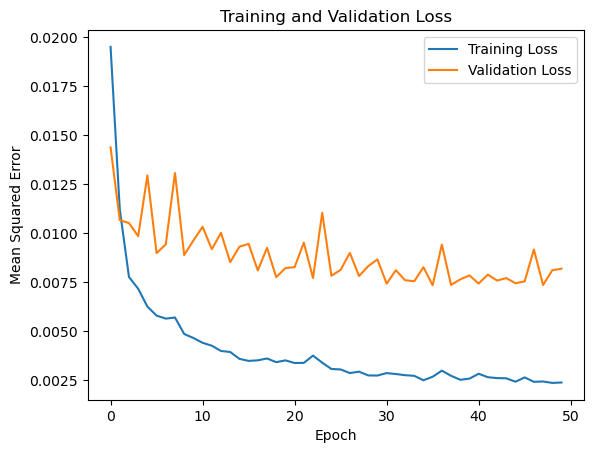

In [255]:
import matplotlib.pyplot as plt

plt.plot(training_loss_2, label='Training Loss')
plt.plot(validation_loss_2, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [256]:
test_mse_2 = model_2.evaluate(X_test_2, y_test_2, verbose=0)
print(f"Mean Squared Error on test set: {test_mse_2}")


Mean Squared Error on test set: 0.008185709826648235


In [257]:
# Calculate RMSE from the given MSE
rmse_standardized_2 = np.sqrt(test_mse_2)

# Create a dummy array with this RMSE value in the first column and zeros elsewhere
rmse_array_standardized_2 = np.zeros((1, num_original_features))
rmse_array_standardized_2[0, 0] = rmse_standardized_2

# Now inverse transform this array
rmse_real_value_array_2 = scaler.inverse_transform(rmse_array_standardized_2)

# Extract the RMSE in real value terms
rmse_real_value_2 = rmse_real_value_array_2[0, 0]
rmse_real_value_2

17.00436286913409

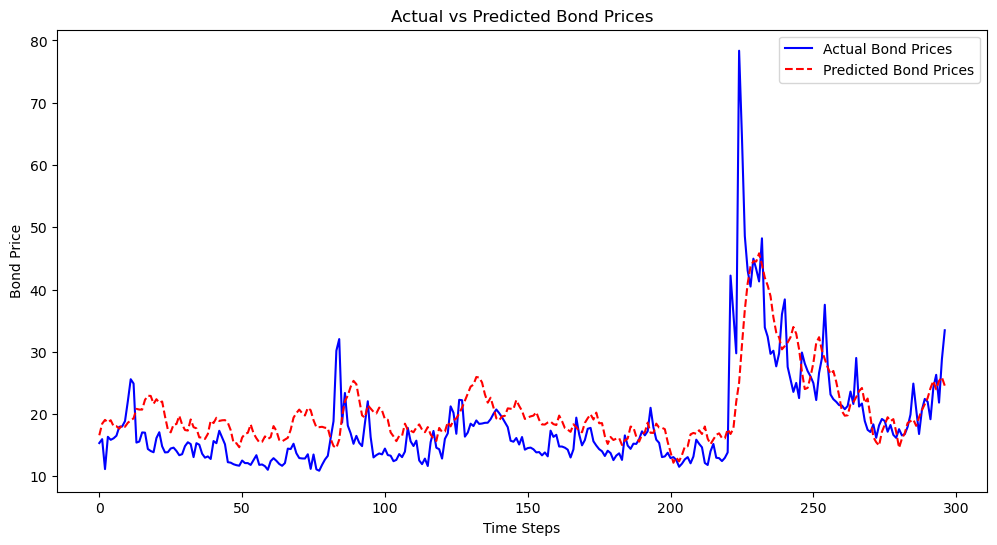

In [258]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Preparing the data for inverse transformation
# ----------------------------------------------

# Convert y_test to a 2D array for compatibility with the transformation process
y_test_2d = y_test_2.reshape(-1, 1)

# Number of original features minus 'Date'
num_original_features = features_2.shape[1] - 1

# Create a placeholder array with adjusted size
placeholder_array = np.zeros((y_test_2d.shape[0], num_original_features))

# Assign the bond prices from y_test to the first column of this placeholder array.
placeholder_array[:, 0] = y_test_2d.ravel()

# Step 2: Performing the inverse transformation
# ----------------------------------------------
actual_prices_2 = scaler.inverse_transform(placeholder_array)[:, 0]

# Step 3: Plotting the actual vs predicted bond prices
# ----------------------------------------------------

predicted_prices_2 = final_predicted_bond_price_2

plt.figure(figsize=(12, 6))
plt.plot(actual_prices_2, label="Actual Bond Prices", color='blue')
plt.plot(predicted_prices_2, label="Predicted Bond Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Bond Prices")
plt.xlabel("Time Steps")
plt.ylabel("Bond Price")
plt.show()

In [259]:
mse_2 = history_2.history['val_loss'][-1]  # Taking the last value from the validation loss
standard_error_2 = np.sqrt(mse_2)
confidence_margin_2 = 1.96 * standard_error_2

# Convert y_train to a 2D array for compatibility
y_train_2d = y_train_2.reshape(-1, 1)

# Create a placeholder array for y_train with adjusted size
placeholder_array_train = np.zeros((y_train_2d.shape[0], num_original_features))

# Assign the bond prices from y_train to the first column of this placeholder array
placeholder_array_train[:, 0] = y_train_2d.ravel()

# Perform the inverse transformation
actual_train_prices_2 = scaler.inverse_transform(placeholder_array_train)[:, 0]

predicted_train_bond_price_2 = model_2.predict(X_train_2)

# Create a dummy array for inverse transformation
temp_array_train = np.zeros((predicted_train_bond_price_2.shape[0], num_original_features))

# Fill the first column with `predicted_train_bond_price` values
temp_array_train[:, 0] = predicted_train_bond_price_2.ravel()

# Now inverse transform this array
inverse_transformed_train = scaler.inverse_transform(temp_array_train)

# Extract the bond_price predictions for the training set
final_predicted_train_bond_price_2 = inverse_transformed_train[:, 0]

24/24 [==============================] - 0s 6ms/step


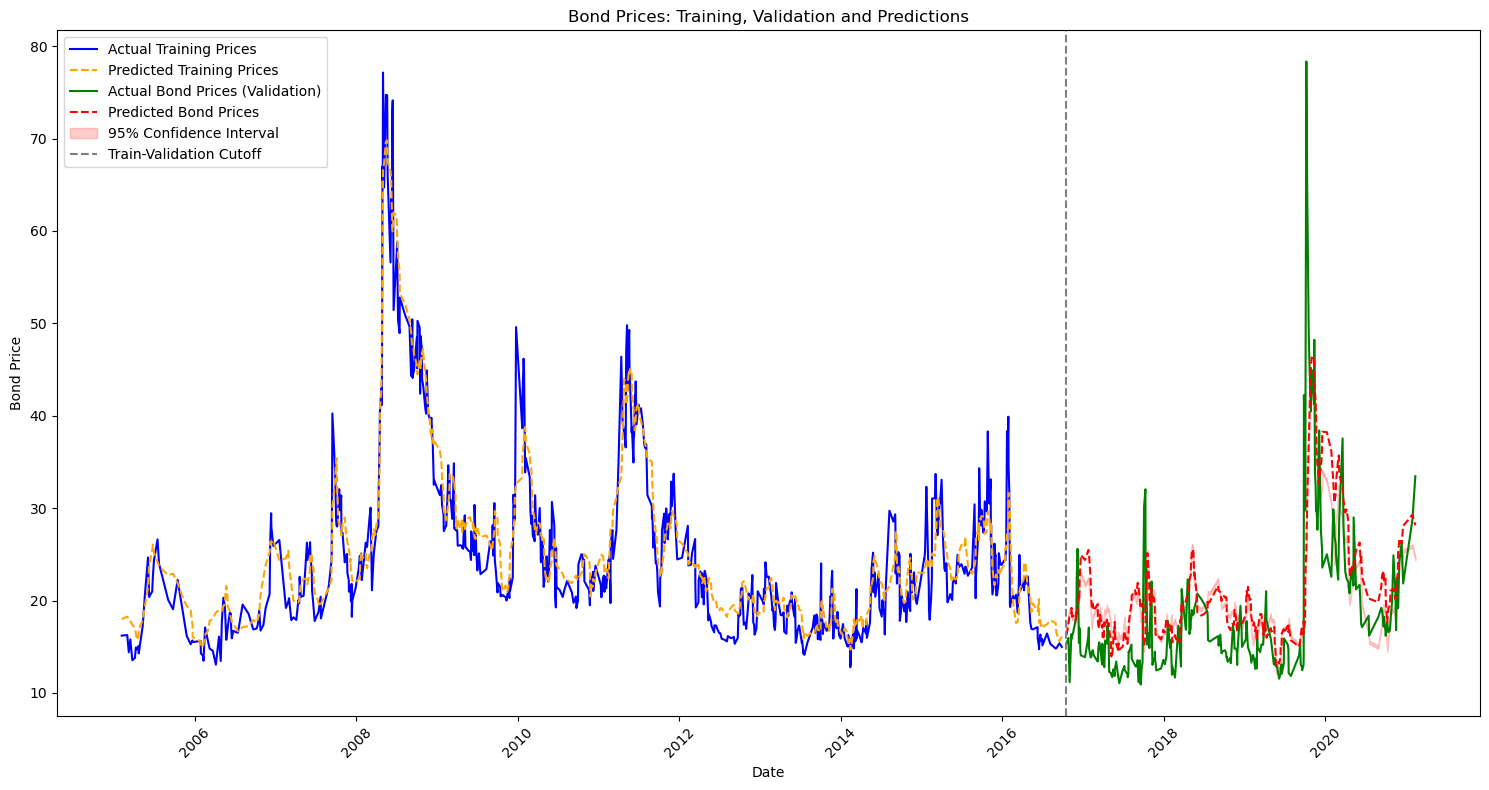

In [260]:
plt.figure(figsize=(15, 8))

# Plotting the training data with actual_train_prices
plt.plot(dates_series[:len(actual_train_prices_2)], actual_train_prices_2, label="Actual Training Prices", color='blue')

# Plotting the predicted bond prices for the training set
plt.plot(dates_series[:len(final_predicted_train_bond_price_2)], final_predicted_train_bond_price_2, label="Predicted Training Prices", color='orange', linestyle='dashed')

# Plotting the validation data (actual prices)
plt.plot(dates_series[len(actual_train_prices_2):len(actual_train_prices_2) + len(y_test)], actual_prices_2, label="Actual Bond Prices (Validation)", color='green')

# Plotting the predicted prices
plt.plot(dates_series[len(y_train_2):len(y_train_2) + len(y_test_2)], predicted_prices, label="Predicted Bond Prices", color='red', linestyle='dashed')

# Shading the 95% confidence interval
plt.fill_between(dates_series[len(y_train_2):len(y_train_2) + len(y_test_2)], 
                 (predicted_prices_2 - confidence_margin_2), 
                 (predicted_prices_2 + confidence_margin_2), 
                 color='red', 
                 alpha=0.2,
                 label='95% Confidence Interval')

# Highlighting the training-validation cutoff
plt.axvline(x=dates_series[len(y_train_2)], color='grey', linestyle='--', label="Train-Validation Cutoff")

plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.legend()
plt.title("Bond Prices: Training, Validation and Predictions")
plt.xlabel("Date")
plt.ylabel("Bond Price")
plt.tight_layout()
plt.show()

In [262]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the hyperparameter grid
lstm_units_options = [30, 50, 70]
optimizers = [Adam(learning_rate=0.001), SGD(), RMSprop()]
dropout_rates = [0.1, 0.2, 0.3]

# Use grid search for hyperparameter tuning
best_val_loss = float('inf')
best_params = {}

for lstm_units in lstm_units_options:
    for optimizer in optimizers:
        for dropout_rate in dropout_rates:
            
            optimizer = clone_optimizer(optimizer)
            model = build_model(lstm_units=lstm_units, optimizer=optimizer, dropout_rate=dropout_rate, sequence_length=sequence_length, num_features=num_features)
            
            early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)
            
            history = model_2.fit(X_train_2, y_train_2, epochs=50, batch_size=100, validation_data=(X_test_2, y_test_2), callbacks=[early_stopping, reduce_lr], verbose=0)
            
            # Get the best validation loss
            val_loss = min(history_2.history['val_loss'])
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'lstm_units': lstm_units,
                    'optimizer': optimizer,
                    'dropout_rate': dropout_rate
                }

print(f"Best validation loss: {best_val_loss}")
print("Best hyperparameters:", best_params)


Best validation loss: 0.007340496405959129
Best hyperparameters: {'lstm_units': 30, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x7efd42d1ee50>, 'dropout_rate': 0.1}
